# Deep learning classifiers for urban sound data - Project Machine Learning II

## Índice
1. Imports and Setup
2. Data exploration
3. Data pre-processing and preparation
4. Model architecture definition
5. Training strategies
6. Performance evaluation 

#### 1. Import and Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import librosa
import IPython.display as ipd
import librosa.display


#### 2. Data exploration

Antes de definir o _pipeline_ de pré-processamento e os modelos de _deep learning_,
é importante compreender a estrutura do UrbanSound8K. Em particular, interessa-nos:

- quantos exemplos existem no total;
- como estão distribuídos pelas diferentes classes;
- de que forma os `folds` 1–10 pré-definidos pelo dataset afectam essa distribuição.


In [4]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
print("The dataset contains:", df.shape, "rows and columns.") 
df.head()

The dataset contains: (8732, 8) rows and columns.


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


O ficheiro `UrbanSound8K.csv` contém, para cada excerto de áudio:

- o **nome do ficheiro** (`slice_file_name`);
- o **fold** (`fold`) a que pertence (de 1 a 10), que será usado na _cross-validation_;
- o **identificador numérico** da classe (`classID`);
- a **etiqueta textual** da classe (`class`), por exemplo `dog_bark`, `siren`, `jackhammer`.
- o **salience** representa a saliência do som, é 1 quando está destacado e 2 quando tem mais barulho de fundo.
- o **fsID**, **start** e **end** contém infromação sobre o aúdio original que não iremos utilizar.

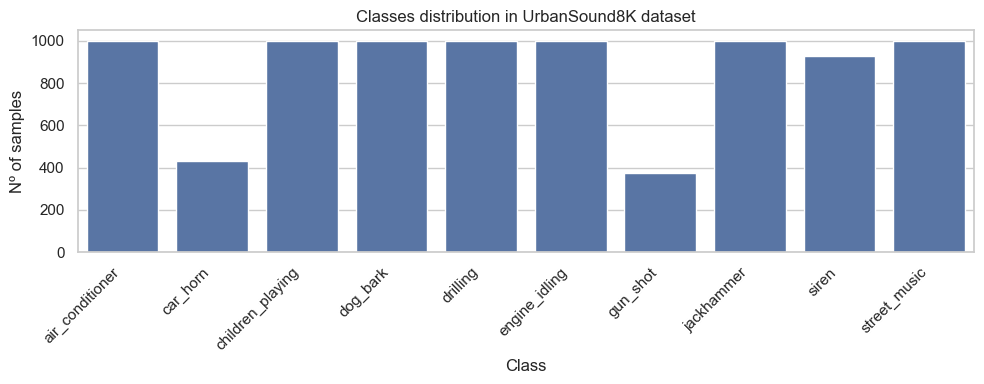

In [18]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="class", order=sorted(df["class"].unique()))
ax.set_title("Classes distribution in UrbanSound8K dataset")
ax.set_xlabel("Class"); ax.set_ylabel("Nº of samples")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.show()

A Figura acima mostra o número de exemplos em cada uma das 10 classes do UrbanSound8K.

Observa-se que:

- a maioria das classes tem cerca de 1000 exemplos, sem grandes
  assimetrias extremas;
- ainda assim, classes como **car_horn** e **gun_shot** apresentam um número
  visivelmente inferior de amostras.

Isto decorre do próprio desenho do UrbanSound8K, que não é perfeitamente balanceado entre classes. Assim, as classes minoritárias
tenderão a ser mais difíceis de aprender e os modelos podem ficar ligeiramente
enviesados para as classes mais frequentes.

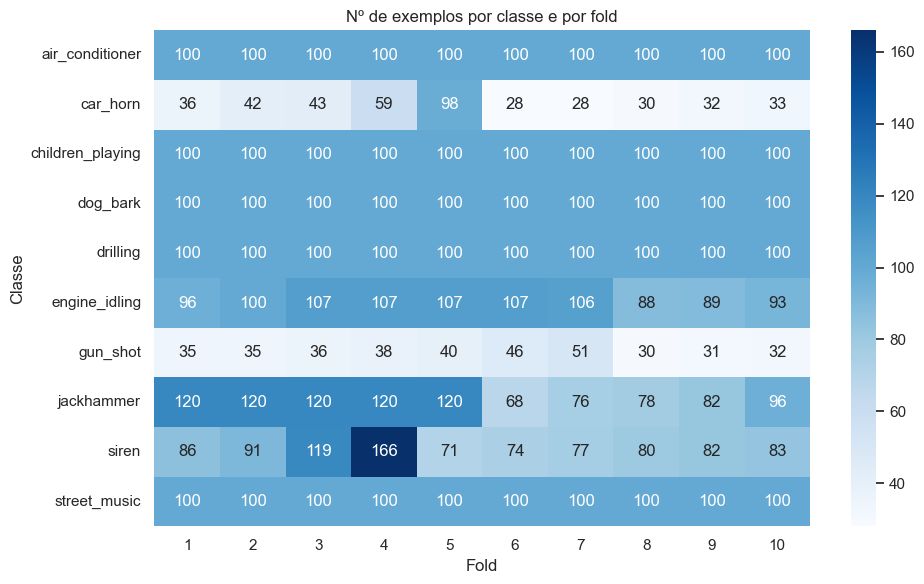

In [19]:
# Tabela fold x classe
counts = df.groupby(["class", "fold"]).size().unstack("fold").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(counts, annot=True, fmt=".0f", cmap="Blues")
plt.title("Nº de exemplos por classe e por fold")
plt.xlabel("Fold")
plt.ylabel("Classe")
plt.tight_layout()
plt.show()



Podemos concluir do gráfico acima que exitem:
- Classes quase perfeitas: air_conditioner, children_playing, dog_bark, drilling, street_music com 100 exemplos por fold.

- Classes com pequenas oscilações: engine_idling, gun_shot, que variam de forma pouco drástica.

- Classes com oscilações fortes:
    - car_horn: de 28 a 98 por fold;
    - jackhammer: de 68 a 120 (e sempre alto nos primeiros folds);
    - siren: de 71 a 166 (em que o fold 4 tem maior representação).

Perguntei ao professor e ele disse que de facto este é um problema que ainda está aberto na área e que podemos meter na conslusão que de facto o modelo tem uma pior performance nas classes com menos representação e que future work seria usar estratégias como SMOTE para class imbalance.

- escolher métricas adequadas (por exemplo, *per-class accuracy* ou *macro F1*);
- usar, se necessário, técnicas como **class weighting** ou **data augmentation** nas classes
  minoritárias;



#### 3. Data pre-processing and preparation

Nesta secção definimos o _pipeline_ de pré-processamento de áudio que será usado para alimentar os classificadores _deep learning_. Em particular, vamos:

- garantir que todos os clipes de áudio têm a mesma duração e frequência de amostragem;
- extrair duas representações distintas do som:
  - **log-mel-spectrogramas 2D**, adequados para redes convolucionais (CNN);
  - **vetores de MFCCs agregados**, adequados para redes totalmente ligadas (MLP);
- preparar funções auxiliares que mais tarde serão integradas nos `Dataset`/`DataLoader` de treino, validação e teste;
- definir, desde já, funções de *data augmentation* (aplicadas apenas em treino) que permitem aumentar a variabilidade dos exemplos.

Estas etapas garantem que os modelos recebem entradas com dimensão fixa e características informativas, mantendo a consistência entre os diferentes folds do UrbanSound8K.


##### 3.1. Caminhos e parâmetros globais de áudio

In [8]:
AUDIO_DIR = "./UrbanSound8K/audio"  # diretório base dos ficheiros .wav

# Parâmetros de áudio
SAMPLE_RATE = 22050   # Hz (frequência de amostragem alvo)
DURATION = 4.0        # segundos (duração alvo de cada clipe)
N_MELS = 64           # nº de bandas mel (para a CNN)
N_MFCC = 20           # nº de coeficientes MFCC (para a MLP)

# Número de amostras por clipe (waveform) após corte/padding
SAMPLES_PER_CLIP = int(SAMPLE_RATE * DURATION)

def get_audio_path(row):
    """
    Dada uma linha do DataFrame df (UrbanSound8K.csv),
    devolve o caminho completo para o ficheiro .wav correspondente.
    """
    fold = row["fold"]
    filename = row["slice_file_name"]
    return os.path.join(AUDIO_DIR, f"fold{fold}", filename)


##### 3.2. Carregamento de áudio com duração fixa

O UrbanSound8K contém clipes com durações variáveis. No entanto, as redes neuronais
esperam tensores de entrada com dimensão fixa. Assim, definimos uma função que:

1. carrega o áudio com uma frequência de amostragem fixa (`SAMPLE_RATE`);
2. corta o sinal se for maior do que a duração alvo (`DURATION`);
3. aplica *zero-padding* se o sinal for mais curto.

Desta forma, todos os exemplos são representados por `SAMPLES_PER_CLIP` amostras.


In [9]:
def load_fixed_audio(path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """
    Carrega um ficheiro de áudio (.wav) e devolve sempre o mesmo número de samples.
    - se o clipe for maior do que `duration`: é cortado;
    - se for menor: é aplicado zero-padding no fim.
    """
    # Carregar áudio (librosa reamostra automaticamente para `sample_rate`, se necessário)
    y, sr = librosa.load(path, sr=sample_rate)

    target_len = int(sample_rate * duration)

    if len(y) > target_len:
        # cortar (aqui cortamos do início; poderíamos também cortar do centro)
        y = y[:target_len]
    elif len(y) < target_len:
        # padding com zeros no fim
        pad_width = target_len - len(y)
        y = np.pad(y, (0, pad_width))

    return y.astype(np.float32)


##### 3.1.1. Efeito da reamostragem e normalização da duração

Antes de alimentar os modelos, todos os clipes de áudio são:

1. **Reamostrados** para uma frequência de amostragem fixa (`SAMPLE_RATE`), garantindo
   que todos os exemplos têm o mesmo número de amostras por segundo;
2. **Normalizados em duração** para `DURATION` segundos, cortando o excesso ou
   aplicando *zero-padding* se forem mais curtos.

Para ilustrar o impacto destas transformações, comparamos abaixo o mesmo clipe
antes e depois do pré-processamento:
- waveform original vs waveform normalizado;
- parâmetros (frequência de amostragem e duração);
- e opcionalmente o espectrograma de ambos.


In [10]:
# Escolher um exemplo do DataFrame
row = df.iloc[0]
path = get_audio_path(row)
print("Ficheiro de exemplo:", path)

# --- Áudio original (como vem no ficheiro) ---
y_orig, sr_orig = librosa.load(path, sr=None)  # sr=None -> não reamostra

dur_orig = len(y_orig) / sr_orig
print(f"Original - sr: {sr_orig} Hz, n_amostras: {len(y_orig)}, duração: {dur_orig:.2f} s")

# --- Áudio processado (reamostrado + duração fixa) ---
y_proc = load_fixed_audio(path, sample_rate=SAMPLE_RATE, duration=DURATION)

dur_proc = len(y_proc) / SAMPLE_RATE
print(f"Processado - sr: {SAMPLE_RATE} Hz, n_amostras: {len(y_proc)}, duração: {dur_proc:.2f} s")

# Ouvir ambos (cuidado com o volume)
print("\nÁudio original:")
display(ipd.Audio(y_orig, rate=sr_orig))

print("Áudio processado (reamostrado + duração fixa):")
display(ipd.Audio(y_proc, rate=SAMPLE_RATE))


Ficheiro de exemplo: ./UrbanSound8K/audio\fold5\100032-3-0-0.wav
Original - sr: 44100 Hz, n_amostras: 14004, duração: 0.32 s
Processado - sr: 22050 Hz, n_amostras: 88200, duração: 4.00 s

Áudio original:


Áudio processado (reamostrado + duração fixa):


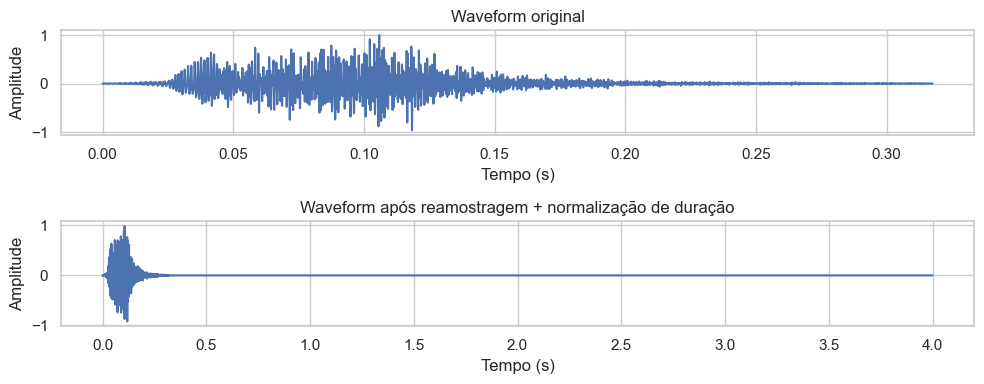

In [11]:
# Criar eixos de tempo para cada waveform
t_orig = np.linspace(0, dur_orig, num=len(y_orig))
t_proc = np.linspace(0, dur_proc, num=len(y_proc))

plt.figure(figsize=(10, 4))

plt.subplot(2, 1, 1)
plt.plot(t_orig, y_orig)
plt.title("Waveform original")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t_proc, y_proc)
plt.title("Waveform após reamostragem + normalização de duração")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


##### 3.3. Extração de log-mel-spectrogramas (CNN)

Para a CNN vamos representar cada clipe como uma "imagem" 2D:

- eixo horizontal: tempo;
- eixo vertical: frequência na escala **mel**;
- intensidade: energia (em escala logarítmica).

Esta representação é obtida da seguinte forma:

1. cálculo de um **mel-spectrograma** a partir do waveform;
2. conversão para **escala logarítmica** (dB), resultando num log-mel-spectrograma.

O resultado é uma matriz de dimensão `N_MELS x T`, onde `T` é o número de _frames_
temporais. Mais à frente, ao construir os `Dataset`/`DataLoader`, asseguraremos que
todas as "imagens" têm o mesmo tamanho e que são normalizadas com base nas estatísticas
do conjunto de treino.


In [12]:
def extract_logmel(y, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    """
    Recebe um waveform y e devolve um log-mel-spectrograma 2D (n_mels x time).
    """
    # 1) mel-spectrograma (energia por banda mel ao longo do tempo)
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=n_mels,
        power=2.0      # potência (energia)
    )

    # 2) conversão para dB (escala logarítmica)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    return log_mel_spec.astype(np.float32)


##### 3.4. Extração de vetores de MFCCs agregados (MLP)

Para a MLP vamos usar uma representação mais compacta do som:

1. para cada clipe calculamos **MFCCs** (Mel-Frequency Cepstral Coefficients),
   resultando numa matriz de dimensão `N_MFCC x T`;
2. agregamos estes coeficientes ao longo do tempo, por exemplo através de:
   - média de cada coeficiente;
   - desvio padrão de cada coeficiente;

obtendo assim um vetor 1D de dimensão `2 * N_MFCC` que resume o conteúdo espectral
do clipe. Este vetor tem dimensão fixa e é adequado para ser usado como entrada
de uma rede totalmente ligada (MLP).


In [13]:
def extract_mfcc_vector(y, sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Recebe um waveform y e devolve um vetor 1D de MFCCs agregados no tempo.
    Exemplo: concatenação da média e do desvio padrão de cada coeficiente.
    """
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sample_rate,
        n_mfcc=n_mfcc
    )  # shape: (n_mfcc, n_frames)

    # Agregação ao longo do tempo
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)

    # Vetor final: [mean_1, ..., mean_n, std_1, ..., std_n]
    mfcc_features = np.concatenate([mfcc_mean, mfcc_std], axis=0)

    return mfcc_features.astype(np.float32)


##### 3.5. Data augmentation em áudio (apenas para treino)

Para melhorar a capacidade de generalização dos modelos, iremos aplicar *data augmentation*
apenas nos exemplos de treino, antes da extração de _features_. As transformações escolhidas
são simples e conservadoras, de forma a não alterar a classe do som:

- **additive noise**: adicionar um ruído gaussiano fraco ao sinal;
- **time-shift**: deslocar ligeiramente o sinal no tempo;
- **time-stretch leve**: tornar o clipe um pouco mais rápido ou mais lento, voltando
  depois a ajustá-lo à duração alvo.

As funções abaixo não são ainda chamadas nesta fase; serão utilizadas posteriormente,
na definição do `Dataset` de treino.
!!!!! Covém confirmar com o professor se podemos fazer isto sem alterar os fold pre-definidos

In [14]:
import random

def add_noise(y, noise_factor=0.02):
    """
    Adiciona ruído gaussiano fraco ao sinal.
    noise_factor controla a intensidade relativa do ruído.
    """
    noise = np.random.randn(len(y))
    augmented = y + noise_factor * noise
    return augmented.astype(np.float32)

def time_shift(y, max_shift_fraction=0.2):
    """
    Desloca o sinal no tempo.
    max_shift_fraction = fracção máxima do comprimento a deslocar.
    """
    max_shift = int(len(y) * max_shift_fraction)
    shift = random.randint(-max_shift, max_shift)
    shifted = np.roll(y, shift)
    return shifted.astype(np.float32)

def time_stretch(y, rate_low=0.9, rate_high=1.1):
    """
    Time-stretch leve: torna o áudio um pouco mais rápido ou lento.
    No fim, volta a ajustar para o tamanho original com padding/corte.
    """
    rate = np.random.uniform(rate_low, rate_high)
    stretched = librosa.effects.time_stretch(y, rate)

    # voltar ao comprimento original
    if len(stretched) > len(y):
        stretched = stretched[:len(y)]
    elif len(stretched) < len(y):
        pad_width = len(y) - len(stretched)
        stretched = np.pad(stretched, (0, pad_width))

    return stretched.astype(np.float32)

def augment_audio(y, apply_noise=True, apply_shift=True, apply_stretch=False):
    """
    Aplica, de forma aleatória, algumas transformações de data augmentation.
    Esta função será usada apenas em exemplos de treino.
    """
    y_aug = y.copy()

    if apply_noise and random.random() < 0.5:
        y_aug = add_noise(y_aug)

    if apply_shift and random.random() < 0.5:
        y_aug = time_shift(y_aug)

    if apply_stretch and random.random() < 0.3:
        y_aug = time_stretch(y_aug)

    return y_aug


##### 3.6. Verificação inicial do pipeline de pré-processamento

Antes de avançar para a definição dos modelos, verificamos se as funções de
carregamento e extração de _features_ se comportam como esperado num exemplo
simples do UrbanSound8K.


Exemplo de ficheiro de áudio: ./UrbanSound8K/audio\fold5\100032-3-0-0.wav
Waveform shape: (88200,)
Log-mel shape (n_mels x time): (64, 173)
MFCC vector shape: (40,)


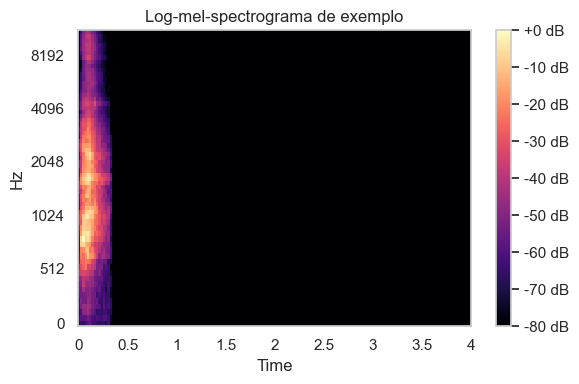

In [15]:
# Escolher um exemplo do DataFrame
example_row = df.iloc[0]
example_path = get_audio_path(example_row)
print("Exemplo de ficheiro de áudio:", example_path)

# Waveform com duração fixa
y = load_fixed_audio(example_path)
print("Waveform shape:", y.shape)

# Log-mel-spectrograma (para a CNN)
log_mel = extract_logmel(y)
print("Log-mel shape (n_mels x time):", log_mel.shape)

# Vetor de MFCCs agregados (para a MLP)
mfcc_vec = extract_mfcc_vector(y)
print("MFCC vector shape:", mfcc_vec.shape)

# Opcional: ouvir o áudio e visualizar o espectrograma
display(ipd.Audio(y, rate=SAMPLE_RATE))

plt.figure(figsize=(6, 4))
librosa.display.specshow(log_mel, sr=SAMPLE_RATE, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-mel-spectrograma de exemplo")
plt.tight_layout()
plt.show()


Além do log-mel-spectrograma, que será usado como entrada da CNN, podemos inspecionar
o vetor de MFCCs agregados que servirá de entrada para a MLP. Cada barra no gráfico
corresponde a uma feature numérica (coeficiente MFCC médio ou desvio padrão) deste clipe.


In [17]:
# Visualizar o vetor de MFCCs agregados (input da MLP)
print("Valores do vetor MFCC:", list[mfcc_vec])

Valores do vetor MFCC: list[array([-5.9222247e+02,  5.5740514e+00, -1.0476468e+01, -5.2723722e+00,
       -1.0548183e+00, -2.3633459e+00, -3.0192697e-01,  1.0254046e+00,
        1.1024994e+00,  6.6860217e-01, -5.5734491e-01, -2.6747948e-01,
       -1.0505089e+00,  4.8320770e-01, -2.3346704e-01, -4.5534027e-01,
       -1.2913095e+00, -5.2421447e-02, -1.1618857e-01,  5.4438192e-01,
        1.1926790e+02,  1.9307783e+01,  3.4108513e+01,  1.7263634e+01,
        4.7783957e+00,  9.7486267e+00,  1.8795525e+00,  3.8568587e+00,
        3.8075886e+00,  2.8143618e+00,  2.6950965e+00,  1.4781656e+00,
        3.9989703e+00,  1.8091406e+00,  1.5632513e+00,  1.9547031e+00,
        4.3257847e+00,  1.4251807e+00,  1.4478124e+00,  1.9533737e+00],
      dtype=float32)]
